In [14]:
from astropy.io import ascii
from astropy import wcs
from astropy.table import Table
from astropy.table import Column

import spectrum
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [15]:
def extract(c, mask):
    ww = c.grid()
    ss = np.zeros_like(ww)
    for i,w in enumerate(ww):
        ss[i] = np.sum( c.data[i][mask] )
    return ww,ss

In [16]:
def project(c,t):
    # project ra/dec from ifu star list to x,y
    ii = t['col1'] < 0.
    xx = []
    yy = []
    for i,r in enumerate(t):
        id,ra,dec = r["col2"], r["col3"], r["col4"]
        cos_term = np.cos(np.deg2rad(dec))
        w = wcs.WCS(c.hdu.header)
        #w.dropaxis(2)
        x,y,w = w.wcs_world2pix(ra,dec,5000.,0)

        shape = c.data.shape
        xx.append(x)
        yy.append(y)
        #if r['col2'] == 1237651753997238489:
        #    print(r['col2'], x,y, shape[2], shape[1])
        if x >= 0 and x <= shape[2] \
            and y >= 0 and y <= shape[1]:
                #print(x,y,w)
                ii[i] = True
                #print(True)

    t.add_column(Column(data=xx, name="x"))
    t.add_column(Column(data=yy, name="y"))
    return t[ii]


In [21]:
def extract_all_in_ifu(c, t, ifu, umag_min=16., umag_max=23., gmag_min=16., gmag_max=23., threshold=50.):
    # for all positions that fall into the IFU extract a spectrum
    xx,yy = np.arange(c.data.shape[2]), np.arange(c.data.shape[1])
    XX,YY = np.meshgrid(xx,yy)

    # take median collapsed cube a slice
    sl = mm
    spectra = {}
    
    for r in t:
        print("### ", r["col2"], " ###")
        if not (r['col5'] <= umag_max and r['col5'] <= gmag_max):
            print("   Did not survice mag cut.")
            continue
        
        #r = t[ii][0]

        # take initial values for position 
        dd = np.sqrt( (XX-r['x'])**2. + (YY-r['y'])**2. )

        jj = dd < 10.

        # compute moments
        M = np.sum(sl[jj])
        x_com = np.sum(sl[jj]*XX[jj])/M
        y_com = np.sum(sl[jj]*YY[jj])/M

        dx = np.sqrt( np.sum( sl[jj] * (XX[jj] - x_com)**2. ) / M ) * 2.35 # FWHM
        dy = np.sqrt( np.sum( sl[jj] * (YY[jj] - y_com)**2. ) / M ) * 2.35 # FWHM
        size = np.sqrt(dx**2. + dy**2.)
        print("   ", r['col2'], r["col3"], r["col4"], r['x'], r['y'], x_com, y_com, dx, dy, size )

        # recompute
        dd2 = np.sqrt( (XX-x_com)**2. + (YY-y_com)**2. ) 

        # I *think* this is essentially a Kron aperture
        #kk = dd2 <= 2. * size
        # Make it larger to get more
        #kk = dd2 <= 3. * size
        kk = dd2 <= 1. * size

        ww,ss =  extract(c,kk)

        spectra[r['col2']] = (ww,ss)
        
        # discard low flux specra
        mf = np.nanmean(ss)
        if not mf> threshold:
            print("   Discarding {}, for too low mean flux {}.".format(r['col2'], mf))
            continue

            
        #plotting
        f = plt.figure()
        
        w = wcs.WCS(c.hdu.header)
        w = w.dropaxis(2)
    
        ax1 = plt.subplot(121, projection=w)
        mm[mm == 0.] = np.nan
        plt.imshow(mm, origin='bottom')
        plt.plot(r['x'],r['y'],'x', c='white')
        plt.plot(x_com, y_com, 'x', c='red')
        
        ax2 = plt.subplot(122)
        #ax = plt.axes()
        ax2.plot(ww,ss)
        ax2.set_title("{}: {}".format(ifu, r['col2']) )
        ax2.set_xlabel("wl [A]")

        tout = Table([ww,ss], names=["wl","count"])
        
        fnout = "{}.txt".format(r["col2"])

        tout.write(fnout,format="ascii.fixed_width")
        print("Wrote {}.".format(fnout))
        
        f.tight_layout()
        #print(r, x_com, y_com)
        
    return spectra

In [22]:
#ifu_list = ["073", "084", "074", "085", "042", "033", "044", "034", "045", "046", "036", "032"]
ifu_list = ascii.read("../ifu_list_COSMOSA.txt")
#fcube = "data/outcube_median_044.fits.gz"
#fcube = "data/outcube_median_042.fits.gz"
#fcube = "data/outcube_median_036.fits.gz"


fifustars = "../shifts/COSMOS/20180210v006/shout.ifustars"


In [23]:
ls ../data/outcube_COSMOSA_022.fits.gz

../data/outcube_COSMOSA_022.fits.gz


Extracting spectra from IFU 22 ../data/outcube_COSMOSA_022.fits.gz ...
###  1237651753997304207  ###
    1237651753997304207 150.189975 2.155321 65.7060721026 142.300065247 60.9464368171 140.894354569 5.41369620976 5.38693190072 7.63722082662
Wrote 1237651753997304207.txt.
###  1237651753997304198  ###
    1237651753997304198 150.185569 2.151865 97.4068840431 117.416888388 nan nan nan nan nan
   Discarding 1237651753997304198, for too low mean flux 0.0.
Extracting spectra from IFU 23 ../data/outcube_COSMOSA_023.fits.gz ...


/Users/mxhf/.pyenv/versions/3.6.0/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal


###  1237651753997304160  ###
   Did not survice mag cut.
###  1237651753997304148  ###
   Did not survice mag cut.
###  1237651753997304163  ###
   Did not survice mag cut.
###  1237651753997304892  ###
   Did not survice mag cut.
###  1237651753997304584  ###
   Did not survice mag cut.
Extracting spectra from IFU 32 ../data/outcube_COSMOSA_032.fits.gz ...
###  1237651753997304735  ###
   Did not survice mag cut.
###  1237651753997303899  ###
    1237651753997303899 150.166726 2.134344 62.1577645543 95.7393913143 62.4974137276 95.5245805172 5.98509808525 6.08066797138 8.53205262925
Wrote 1237651753997303899.txt.
###  1237651753997303898  ###
    1237651753997303898 150.166726 2.134344 62.1577645543 95.7393913143 62.4974137276 95.5245805172 5.98509808525 6.08066797138 8.53205262925
Wrote 1237651753997303898.txt.
###  1237651753997304139  ###
   Did not survice mag cut.
###  1237651753997304129  ###
    1237651753997304129 150.163933 2.138317 82.2533907618 124.344989229 82.1770086159 1

/Users/mxhf/.pyenv/versions/3.6.0/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt


###  1237651753997239032  ###
   Did not survice mag cut.
###  1237651753997239377  ###
    1237651753997239377 150.155307 2.164833 44.2661840706 145.576773031 45.063094968 127.971617269 nan nan nan
   Discarding 1237651753997239377, for too low mean flux 0.0.
###  1237651753997239053  ###
    1237651753997239053 150.156101 2.157891 38.5533051025 95.5943891045 39.3148236365 94.8638938318 4.7017973291 10.2832434013 11.3071655588
Wrote 1237651753997239053.txt.
Extracting spectra from IFU 34 ../data/outcube_COSMOSA_034.fits.gz ...


/Users/mxhf/.pyenv/versions/3.6.0/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


###  1237651753997238991  ###
   Did not survice mag cut.
###  1237651753997239206  ###
    1237651753997239206 150.133958 2.174966 89.524816003 46.6763774102 88.5737106393 47.6636629642 2.91179020188 5.71271263498 6.41198938159
Wrote 1237651753997239206.txt.
###  1237651753997239020  ###
   Did not survice mag cut.
Extracting spectra from IFU 35 ../data/outcube_COSMOSA_035.fits.gz ...
###  1237651753997238547  ###
   Did not survice mag cut.
###  1237651753997239389  ###
   Did not survice mag cut.
###  1237651753997239182  ###
   Did not survice mag cut.
Extracting spectra from IFU 36 ../data/outcube_COSMOSA_036.fits.gz ...
###  1237651753997238899  ###
   Did not survice mag cut.
###  1237651753997239179  ###
   Did not survice mag cut.
###  1237651753997238926  ###
    1237651753997238926 150.109785 2.223743 54.2847715359 56.3255938045 54.3678127079 56.2410527323 11.8875269553 11.9069908552 16.825270528
   Discarding 1237651753997238926, for too low mean flux -15392.989989667842.
#

/Users/mxhf/.pyenv/versions/3.6.0/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/Users/mxhf/.pyenv/versions/3.6.0/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


###  1237651753997238734  ###
   Did not survice mag cut.
###  1237651753997238739  ###
   Did not survice mag cut.
###  1237651753997238298  ###
    1237651753997238298 150.039218 2.116186 87.7940388971 41.3408903291 88.2437230145 41.6756185462 5.91733039589 6.07548920061 8.48094145958
Wrote 1237651753997238298.txt.
###  1237651753997238761  ###
    1237651753997238761 150.045532 2.1235 42.3643898108 94.0017246833 41.0709410971 94.7944851193 10.4786813023 6.59902454901 12.3834521372
Wrote 1237651753997238761.txt.
###  1237651753997238760  ###
    1237651753997238760 150.045532 2.1235 42.3643898108 94.0017246833 41.0709410971 94.7944851193 10.4786813023 6.59902454901 12.3834521372
Wrote 1237651753997238760.txt.
###  1237651753997238757  ###
    1237651753997238757 150.046986 2.118702 31.9026499477 59.4561586327 nan nan nan nan nan
   Discarding 1237651753997238757, for too low mean flux 0.0.
Extracting spectra from IFU 76 ../data/outcube_COSMOSA_076.fits.gz ...
Extracting spectra from 

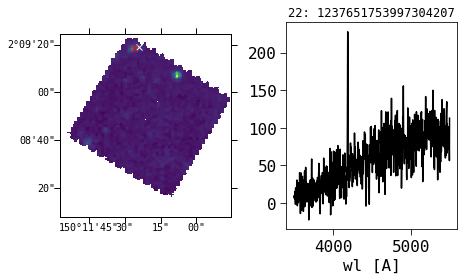

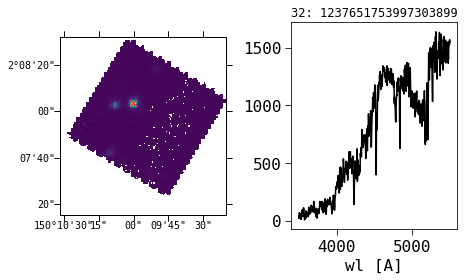

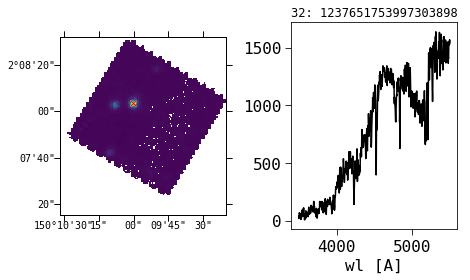

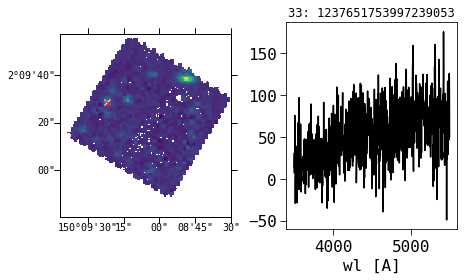

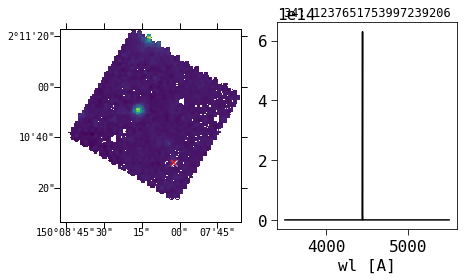

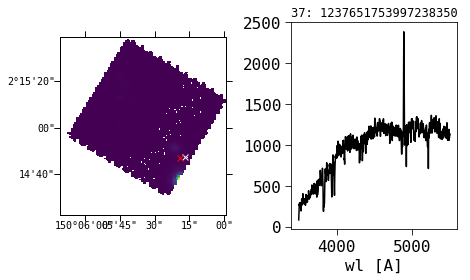

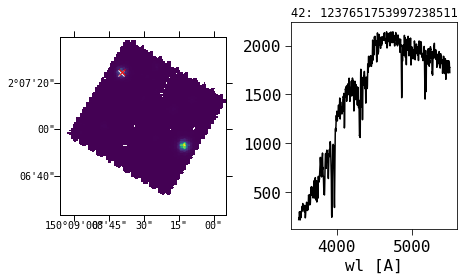

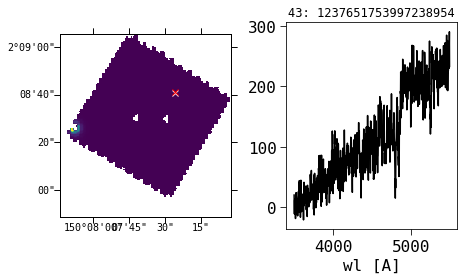

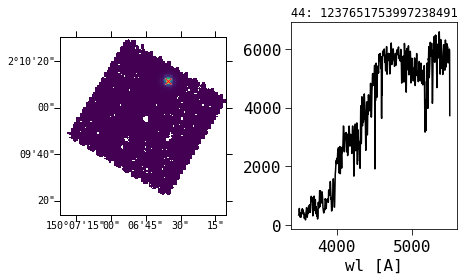

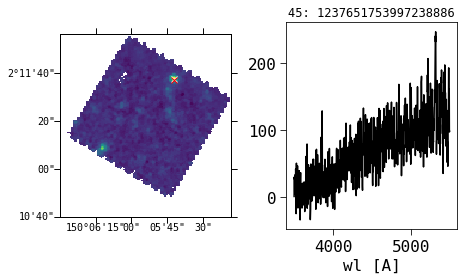

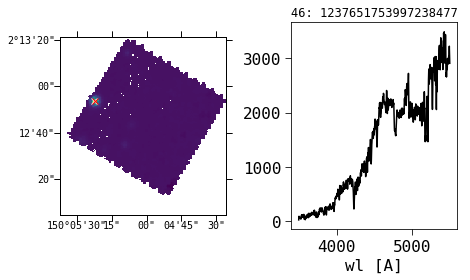

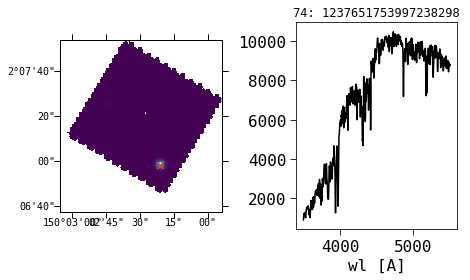

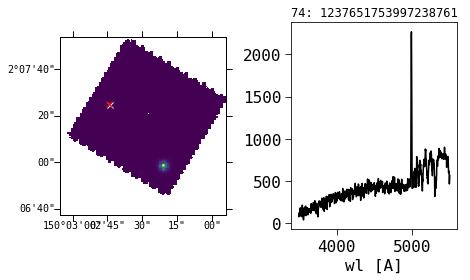

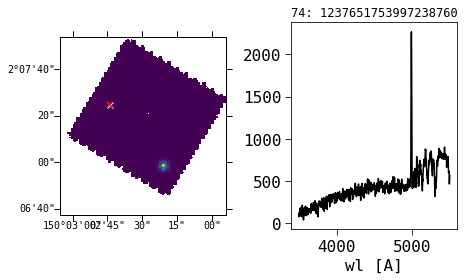

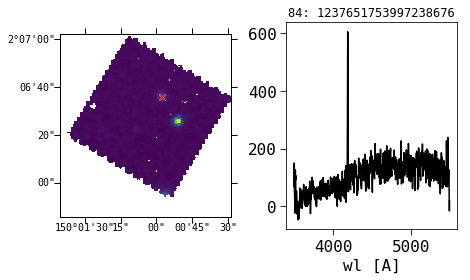

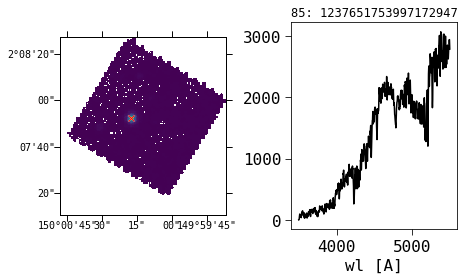

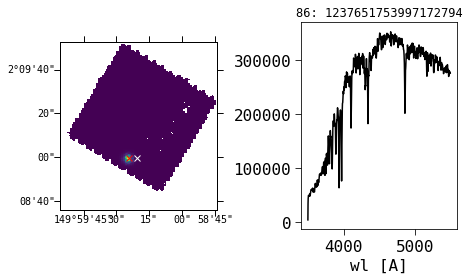

In [25]:
for ifu in ifu_list["ifu"]:
#for ifu in [36]:
    fcube = "../data/outcube_COSMOSA_{:03d}.fits.gz".format(ifu)

    print("Extracting spectra from IFU {} {} ...".format(ifu, fcube))
    t = ascii.read(fifustars)

    # read spectrum
    c = spectrum.readSpectrum(fcube)
    mm = np.nanmedian( c.data, axis = 0 )

    t_inside = project(c,t) # find which stars fall inside the IFU cube footprint (not necessarily the IFU)
                            # also compute x,y coordinates

    extract_all_in_ifu(c, t_inside, ifu)
    
    #break

In [11]:
#!cat shifts/COSMOS/20180210v006/shout.ifustars

In [12]:
good_stars = [
    '1237651753997304198',
    '1237651753997303899',
    #'1237651753997304139', # Galaxy
    #'1237651753997238991', # Galaxy
    '1237651753997238489',
    #'1237651753997238926', # Galaxy
    '1237651753997238511',
    '1237651753997238491',
    '1237651753997238477',
    '1237651753997238298',
    '1237651753997238529',
    '1237651753997172947',
    #'1237651753997172794', # Galaxy
    '1237651753997173416'
]

In [13]:
for s in good_stars:
    !ls $s*

ls: 1237651753997304198*: No such file or directory
ls: 1237651753997303899*: No such file or directory
ls: 1237651753997238489*: No such file or directory
ls: 1237651753997238511*: No such file or directory
ls: 1237651753997238491*: No such file or directory
ls: 1237651753997238477*: No such file or directory
ls: 1237651753997238298*: No such file or directory
ls: 1237651753997238529*: No such file or directory
ls: 1237651753997172947*: No such file or directory
ls: 1237651753997173416*: No such file or directory


# check that application of flux calibration to cube worked well

In [10]:
star_id = 1237651753997238489


Extracting spectra from IFU 36 data/coutcube_median_036.fits.gz ...
###  1237651753997238899  ###
   Did not survice mag cut.
###  1237651753997239179  ###
   Did not survice mag cut.
###  1237651753997238926  ###
    1237651753997238926 150.109785 2.223743 53.387943235900714 57.04835248280951 58.00015927592416 56.870271222237236 7.997518806902537 4.234683917392463 9.049467108453522
###  1237651753997238489  ###
    1237651753997238489 150.103971 2.227918 95.21715657978399 87.10835684932756 96.22974939009197 86.52354083535205 5.93938150230882 6.023449548284706 8.45920782879221
###  1237651753997239177  ###
   Did not survice mag cut.
###  1237651753997238907  ###
    1237651753997238907 150.101614 2.232906 112.17459671164707 123.02200589504075 nan nan nan nan nan
   Discarding 1237651753997238907, for too low mean flux 0.0.


/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal


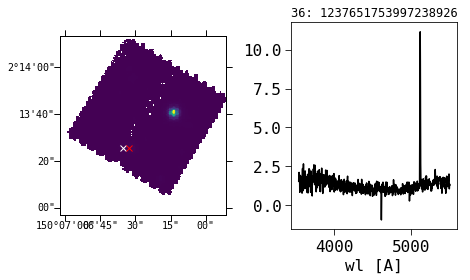

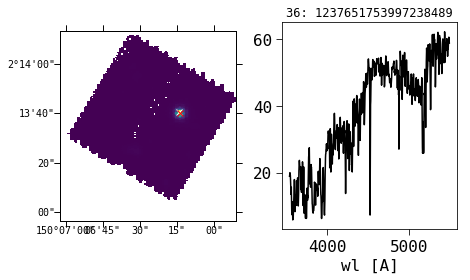

In [11]:
for ifu in [36]:
    fcube = "data/coutcube_median_{:03d}.fits.gz".format(ifu)

    print("Extracting spectra from IFU {} {} ...".format(ifu, fcube))
    t = ascii.read(fifustars)

    # read spectrum
    c = spectrum.readSpectrum(fcube)
    mm = np.nanmedian( c.data, axis = 0 )

    t_inside = project(c,t)
    #ii = t_inside["col2"] == str(star_id)


    spectra = extract_all_in_ifu(c, t_inside, ifu, threshold=0.)

Text(0,0.5,'erg/s/A/cm^2')

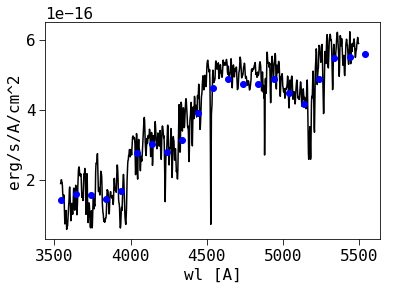

In [12]:
ww,ff  = spectra[star_id]

fsed = "000001_{}.txt".format(star_id)
sed = ascii.read(fsed)
sed = sed[1:]

ax2 = plt.subplot()

plt.plot( ww,ff/1e17  ,'-')
plt.plot( sed["col1"], sed["col2"] ,'o')

ax2.set_xlabel("wl [A]")
ax2.set_ylabel("erg/s/A/cm^2")

# now take the one actually existing SDSS spectrum 3154-54821-0160

In [78]:
for ifu in [73]:
    fcube = "data/coutcube_median_{:03d}.fits.gz".format(ifu)

    print("Extracting spectra from IFU {} {} ...".format(ifu, fcube))

    # read spectrum
    c = spectrum.readSpectrum(fcube)

    
    # for all positions that fall into the IFU extract a spectrum
    xx,yy = np.arange(c.data.shape[2]), np.arange(c.data.shape[1])
    XX,YY = np.meshgrid(xx,yy)

    # take median collapsed cube a slice
    sl = mm
    spectra = {}
    
    xc = 59.230769
    yc = 125.0863
        
    # take initial values for position 
    dd = np.sqrt( (XX-xc)**2. + (YY-yc)**2. )

    jj = dd < 10.

    # compute moments
    M = np.sum(sl[jj])
    x_com = np.sum(sl[jj]*XX[jj])/M
    y_com = np.sum(sl[jj]*YY[jj])/M

    dx = np.sqrt( np.sum( sl[jj] * (XX[jj] - x_com)**2. ) / M ) * 2.35 # FWHM
    dy = np.sqrt( np.sum( sl[jj] * (YY[jj] - y_com)**2. ) / M ) * 2.35 # FWHM
    size = np.sqrt(dx**2. + dy**2.)
    #print("   ", r['col2'], r["col3"], r["col4"], r['x'], r['y'], x_com, y_com, dx, dy, size )

    # recompute
    dd2 = np.sqrt( (XX-x_com)**2. + (YY-y_com)**2. ) 

    # I *think* this is essentially a Kron aperture
    #kk = dd2 <= 2. * size
    # Make it larger to get more
    #kk = dd2 <= 3. * size
    kk = dd2 <= 1. * size

    ww,ss =  extract(c,kk)

Extracting spectra from IFU 73 data/coutcube_median_073.fits.gz ...


In [79]:
from astropy.table import Table

sdss = Table.read("spec-3154-54821-0160.fits")

Text(0.5,0,'wavelength [A]')

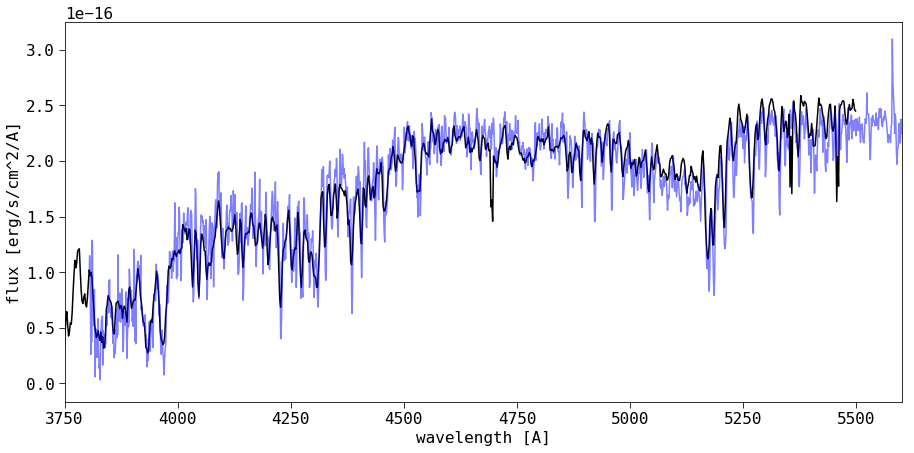

In [87]:
import numpy as np
f = plt.figure(figsize=[15,7])
plt.plot(ww,ss, label='HETDEX')

plt.plot( 10.**( sdss['loglam'] ), sdss['flux']*1e-17, label='sdss', alpha=.5)

plt.xlim([3750.,5600.])

plt.ylabel("flux [erg/s/cm^2/A]")
plt.xlabel("wavelength [A]")